In [1]:
from google.colab import drive
drive.mount('/gdrive')

!pip -q install albumentations==0.4.6
!cp -r /gdrive/MyDrive/Assignment\ 2/* .
# !unzip -q -u /content/data/nuclei.zip  -d /content/data/
# !unzip -q -u "/content/data/lits/imgs.zip" -d /content/data/lits
# !unzip -q -u "/content/data/lits/masks.zip" -d /content/data/lits

Mounted at /gdrive
     |████████████████████████████████| 122kB 36.1MB/s 
     |████████████████████████████████| 952kB 36.7MB/s 


In [1]:
%matplotlib inline
import sys
sys.path.append("..")

import os
import gzip
import torch 
import numpy as np
from torch import nn
from tqdm import tqdm
from PIL import Image
from skimage import io
from pathlib import Path
import albumentations as A
from joblib import load, dump
import matplotlib.pyplot as plt
from torchsummary import summary
from os.path import join, abspath 
from torchvision import transforms
from skimage.transform import resize
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from unet.utils import *
from run import train
from unet.datasets import ISBI, DS_Bowl, BRATS, LITS, ResNetDS_Bowl
from unet.models import UNet, UNetplus, UNetplusplus, ResNetUNet

ISBI_ = abspath("data/isbi")
BOWL_ = abspath("data/nuclei")
BRATS_ = abspath("data/brats13")
LITS_ = abspath("data/lits")
IMG_H, IMG_W = 128, 128

## ISBI Dataset

Training batch shape: torch.Size([1, 1, 128, 128]) torch.Size([1, 1, 128, 128])
Validation batch shape: torch.Size([1, 1, 128, 128]) torch.Size([1, 1, 128, 128])


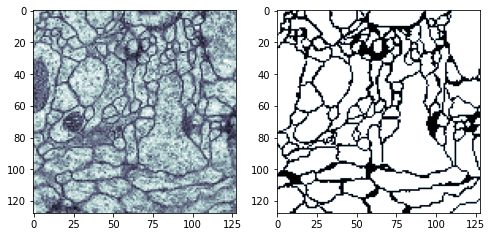

In [ ]:
train_path = join(ISBI_, "train")
val_path = join(ISBI_, "val")

augs = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.RandomBrightnessContrast(brightness_by_max=False, p=0.5),
    A.Flip(p=0.5),
    A.Rotate(p=0.5),
], p=1)

train_d = ISBI(train_path, augs)
train_dl = DataLoader(train_d, batch_size=1, shuffle=True)
img, mask = train_d.__getitem__(10)
visualize(img[0], mask[0])

val_d = ISBI(val_path, augs)
val_dl = DataLoader(val_d, batch_size=1, shuffle=True)

train_features, train_labels = next(iter(train_dl))
val_features, val_labels = next(iter(val_dl))
print("Training batch shape:", train_features.size(), train_labels.size())
print("Validation batch shape:", val_features.size(), val_labels.size())

In [ ]:
model_loc = os.path.join('/gdrive', 'MyDrive', 'Assignment 2', 'models')

# normal unet
unet = UNet(1, 1)
# summary(model, (1, 128, 128))
train(unet, train_dl, val_dl, epochs=200)

# wide unet
filters = [35, 70, 140, 280, 560]
w_unet = UNet(1, 1, filters)
train(w_unet, train_dl, val_dl, epochs=200)

# unet+ without deep supervision
unet_p = UNetplus(1, 1)
train(unet_p, train_dl, val_dl, epochs=200)

# unet+ with deep supervision
unet_p_ds = UNetplus(1, 1, ds=True)
train(unet_p_ds, train_dl, val_dl, ds=True, epochs=200)

# unet++ without deep supervision
unet_pp = UNetplusplus(1, 1)
train(unet_pp, train_dl, val_dl, epochs=200)

# unet++ with deep supervision
unet_pp_ds = UNetplusplus(1, 1, ds=True)
train(unet_pp_ds, train_dl, val_dl, ds=True, epochs=200)

dump([unet, w_unet, unet_p, unet_p_ds, unet_pp, unet_pp_ds], join(model_loc, "isbi_models.joblib"))

2021-07-01 05:45:34,327 - UNet++ - INFO - Started training for unet.pth for 500 epochs
2021-07-01 05:45:36,225 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.19609735906124115 	 Validation Loss: 0.17513200640678406
2021-07-01 05:45:36,376 - UNet++ - DEBUG - Mean IOU: 0.9069820046424866 	 Mean Dice Coef: 0.9352540047236393
2021-07-01 05:47:10,446 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.16605597734451294 	 Validation Loss: 0.19084125757217407
2021-07-01 05:47:10,595 - UNet++ - DEBUG - Mean IOU: 0.9062564969062805 	 Mean Dice Coef: 0.9374711793117109
2021-07-01 05:48:43,531 - UNet++ - DEBUG - Epoch 101 	 Training Loss: 0.16007129848003387 	 Validation Loss: 0.1827402114868164
2021-07-01 05:48:43,682 - UNet++ - DEBUG - Mean IOU: 0.9008166193962097 	 Mean Dice Coef: 0.9323095422368605
2021-07-01 05:50:16,176 - UNet++ - DEBUG - Epoch 151 	 Training Loss: 0.20279741287231445 	 Validation Loss: 0.1966809630393982
2021-07-01 05:50:16,326 - UNet++ - DEBUG - Mean IOU: 0.9050517678260803 	 M

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


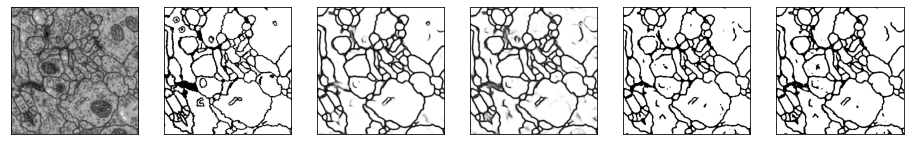

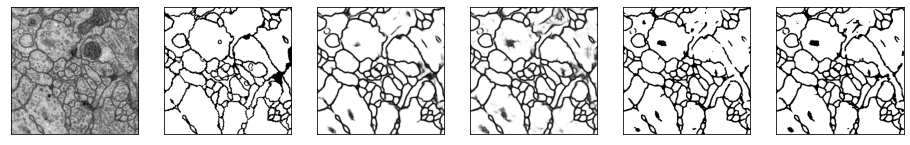

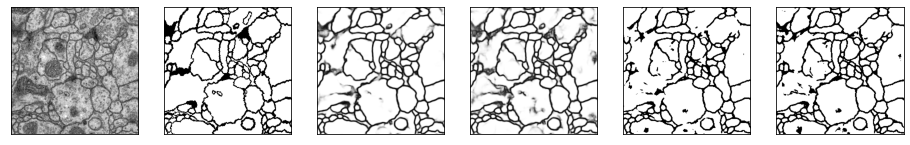

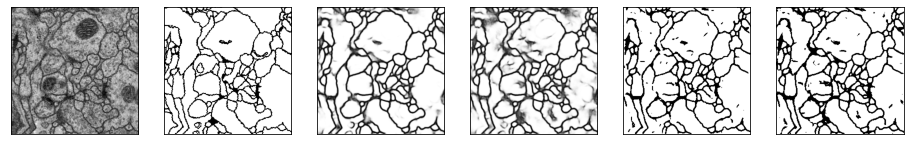

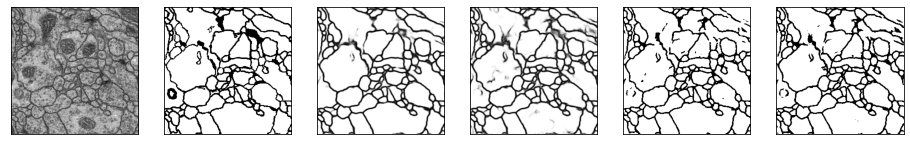

In [ ]:
models = load("models/isbi_models.joblib")

predict_masks(models, val_dl, count=5)
# original image, ground truth, unet, wide unet, unet+, unet++

### 2018 Data Science Bowl 
Nuclei Images

100%|██████████| 670/670 [01:31<00:00,  7.34it/s]


Training batch shape: torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])
Validation batch shape: torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])


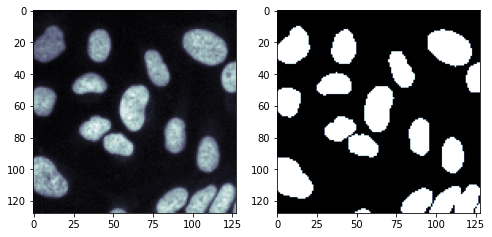

In [ ]:
iaugs = A.Compose([
    A.Resize(IMG_H, IMG_W), 
], p=1)

maugs = A.Compose([
    A.Resize(IMG_H, IMG_W, interpolation=Image.NEAREST)
], p=1)

bowl_ds = DS_Bowl(BOWL_, iaugs, maugs)
img, mask = bowl_ds.__getitem__(10)
visualize(img[0], mask[0])

length = bowl_ds.__len__()
splits = [int(length - 0.2*length), int(0.2*length)] 
bowl_train, bowl_val = random_split(bowl_ds, splits)

bowl_tdl = DataLoader(bowl_train, batch_size=64, shuffle=True)
bowl_vdl = DataLoader(bowl_val, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(bowl_tdl))
val_features, val_labels = next(iter(bowl_vdl))
print("Training batch shape:", train_features.size(), train_labels.size())
print("Validation batch shape:", val_features.size(), val_labels.size())

In [ ]:
model_loc = os.path.join('/gdrive', 'MyDrive', 'Assignment 2', 'models')

# normal unet
unet = UNet(1, 1)
train(unet, bowl_tdl, bowl_vdl, epochs=100)

# wide unet
filters = [35, 70, 140, 280, 560]
w_unet = UNet(1, 1, filters)
train(w_unet, bowl_tdl, bowl_vdl, epochs=100)

# unet+ without deep supervision
unet_p = UNetplus(1, 1)
train(unet_p, bowl_tdl, bowl_vdl, epochs=100)

# unet+ with deep supervision
unet_p_ds = UNetplus(1, 1, ds=True)
train(unet_p_ds, bowl_tdl, bowl_vdl, ds=True, epochs=100)

# unet++ without deep supervision
unet_pp = UNetplusplus(1, 1)
train(unet_pp, bowl_tdl, bowl_vdl, epochs=100)

# unet++ with deep supervision
unet_pp_ds = UNetplusplus(1, 1, ds=True)
train(unet_pp_ds, bowl_tdl, bowl_vdl, ds=True, epochs=100)

dump([unet, w_unet, unet_p, unet_p_ds, unet_pp, unet_pp_ds], join(model_loc, "dsbowl_models.joblib"))

2021-07-05 06:31:45,521 - UNet++ - INFO - Started training for UNet for 100 epochs


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-07-05 06:31:52,841 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.053465478122234344 	 Validation Loss: 0.02597738429903984
2021-07-05 06:31:53,524 - UNet++ - DEBUG - Mean IOU: 0.8867150545120239 	 Mean Dice Coef: 0.9009372564035505
2021-07-05 06:38:17,876 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.0015315867494791746 	 Validation Loss: 0.055035363882780075
2021-07-05 06:38:18,607 - UNet++ - DEBUG - Mean IOU: 0.910047173500061 	 Mean Dice Coef: 0.942681803642115
2021-07-05 06:44:39,012 - UNet++ - INFO - Started training for UNet for 100 epochs
2021-07-05 09:32:03,070 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.06655704230070114 	 Validation Loss: 0.06731440126895905
2021-07-05 09:32:03,481 - UNet++ - DEBUG - Mean IOU: 0.8287834525108337 	 Mean Dice Coef: 0.845497382394753
2021-07-05 09:35:53,007 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.061274655163288116 	 Validation Loss: 0.07983995229005814
2021-07-05 09:35:53,423 - UNet++ - DEBUG - Mean IOU: 0.8482638001441956 	 Mean

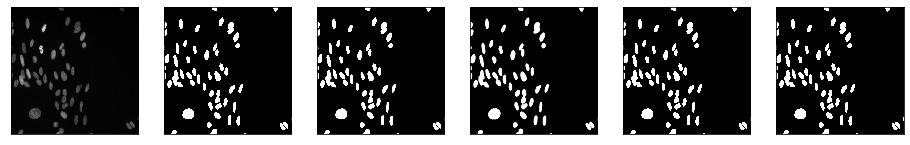

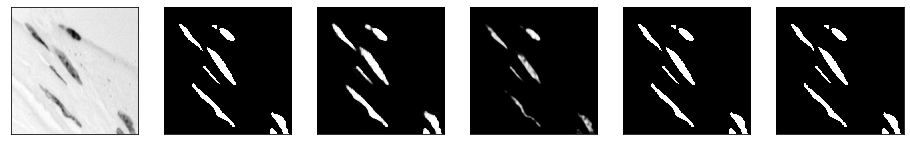

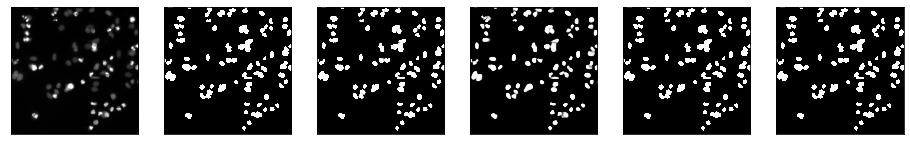

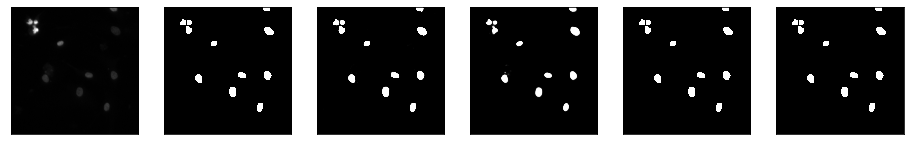

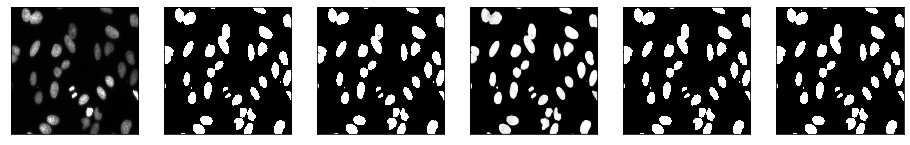

In [ ]:
models = load("models/dsbowl_models.joblib")

predict_masks(models, bowl_vdl, count=5)
# original image, ground truth, unet, wide unet, unet+, unet++

### BRATS '13 Dataset

In [2]:
brats_ds = BRATS(BRATS_)

length = brats_ds.__len__()
splits = [int(np.ceil(length - 0.2*length)), int(0.2*length)] 
brats_train, brats_val = random_split(brats_ds, splits)

brats_tdl = DataLoader(brats_train, batch_size=8, shuffle=True)
brats_vdl = DataLoader(brats_val, batch_size=8, shuffle=True)

train_features, train_labels = next(iter(brats_tdl))
val_features, val_labels = next(iter(brats_vdl))
print("Training batch shape:", train_features.size(), train_labels.size())
print("Validation batch shape:", val_features.size(), val_labels.size())

Training batch shape: torch.Size([8, 4, 240, 240]) torch.Size([8, 1, 240, 240])
Validation batch shape: torch.Size([8, 4, 240, 240]) torch.Size([8, 1, 240, 240])


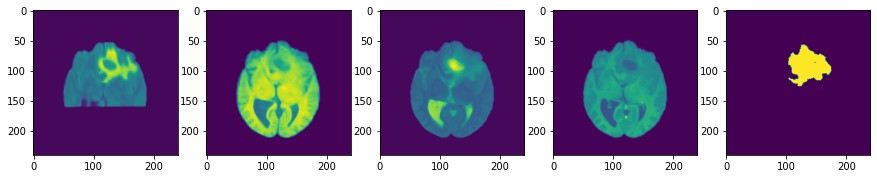

In [ ]:
# for x in range(25):
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
img, mask = brats_ds.__getitem__(30)

ax[0].imshow(img[0])
ax[1].imshow(img[1])
ax[2].imshow(img[2])
ax[3].imshow(img[3])
ax[4].imshow(mask[0])

In [ ]:
model_loc = os.path.join('/gdrive', 'MyDrive', 'Assignment 2', 'models')

# normal unet
unet = UNet(4, 1)
train(unet, brats_tdl, brats_vdl, epochs=101)

# wide unet
filters = [35, 70, 140, 280, 560]
w_unet = UNet(4, 1, filters)
train(w_unet, brats_tdl, brats_vdl, epochs=101)

# unet+ without deep supervision
unet_p = UNetplus(4, 1)
train(unet_p, brats_tdl, brats_vdl, epochs=51)

# unet++ with deep supervision
unet_pp_ds = UNetplusplus(4, 1, ds=True)
train(unet_pp_ds, brats_tdl, brats_vdl, ds=True, epochs=101)

dump([unet, wunet, unet_p, unet_p, unet_pp_ds, unet_pp_ds], join(model_loc, "brats_models.joblib"))

2021-07-11 16:22:43,522 - UNet++ - INFO - Started training for UNet for 101 epochs
2021-07-11 16:23:05,745 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.2716100811958313 	 Validation Loss: 1.0137499570846558
2021-07-11 16:23:07,680 - UNet++ - DEBUG - Mean IOU: 0.05108446627855301 	 Mean Dice Coef: 0.032948826761010394
2021-07-11 16:42:07,268 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.01121938694268465 	 Validation Loss: 0.013579817488789558
2021-07-11 16:42:09,291 - UNet++ - DEBUG - Mean IOU: 0.9519259929656982 	 Mean Dice Coef: 0.8992396605479082
2021-07-11 17:01:13,135 - UNet++ - DEBUG - Epoch 101 	 Training Loss: 0.005973621271550655 	 Validation Loss: 0.010549398139119148
2021-07-11 17:01:15,161 - UNet++ - DEBUG - Mean IOU: 0.954026460647583 	 Mean Dice Coef: 0.913908419710338
2021-07-11 17:01:15,245 - UNet++ - INFO - Started training for UNet for 101 epochs
2021-07-11 17:01:29,526 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.36979418992996216 	 Validation Loss: 0.378243535757

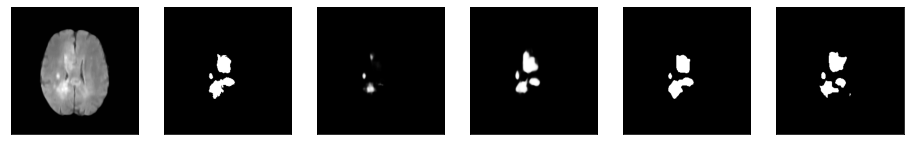

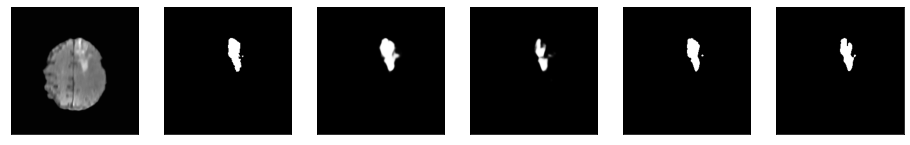

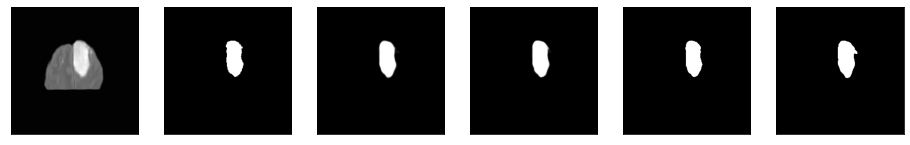

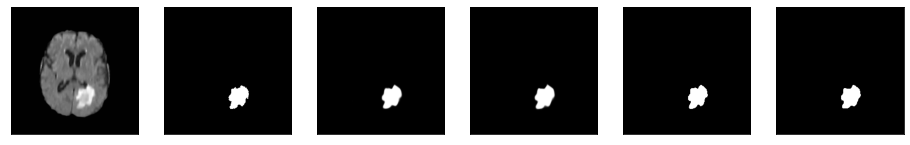

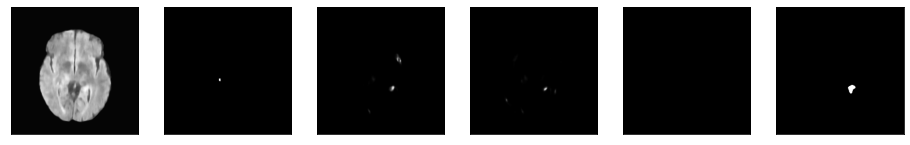

In [12]:
models = load("models/brats_models.joblib")

plot_masks(models, brats_vdl, count=5)
# original image, ground truth, unet, wide unet, unet+, unet++

### MICCAI 2017 LiTS Dataset
CT scans

Training batch shape: torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])
Validation batch shape: torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])


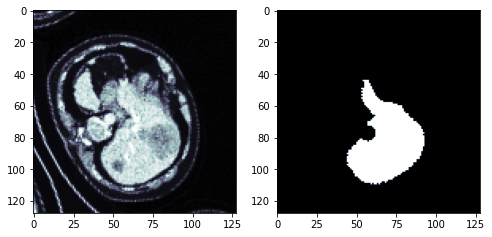

In [ ]:
augs = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.RandomBrightnessContrast(brightness_by_max=False, p=0.5),
    A.Flip(p=0.5),
    A.Rotate(p=0.5),
], p=1)

lits_ds = LITS(LITS_, augs)
img, mask = lits_ds.__getitem__(10)
visualize(img[0], mask[0])

length = lits_ds.__len__()
splits = [int(np.ceil(length - 0.2*length)), int(0.2*length)] 
lits_train, lits_val = random_split(lits_ds, splits)

lits_tdl = DataLoader(lits_train, batch_size=64, shuffle=True)
lits_vdl = DataLoader(lits_val, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(lits_tdl))
val_features, val_labels = next(iter(lits_vdl))
print("Training batch shape:", train_features.size(), train_labels.size())
print("Validation batch shape:", val_features.size(), val_labels.size())

In [ ]:
model_loc = os.path.join('/gdrive', 'MyDrive', 'Assignment 2', 'models')

# normal unet
unet = UNet(1, 1, 2)
# summary(model, (1, 128, 128))
train(unet, lits_tdl, lits_vdl, epochs=51)

# wide unet
filters = [35, 70, 140, 280, 560]
w_unet = UNet(1, 1, filters)
train(w_unet, lits_tdl, lits_vdl, epochs=51)

# unet+ with deep supervision
unet_p_ds = UNetplus(1, 1, 2, ds=True)
train(unet_p_ds, lits_tdl, lits_vdl, ds=True, epochs=51)

# unet++ with deep supervision
unet_pp_ds = UNetplusplus(1, 1, 2, ds=True)
train(unet_pp_ds, lits_tdl, lits_vdl, ds=True, epochs=51)

dump([unet, w_unet, unet_p_ds, unet_p_ds, unet_pp_ds, unet_pp_ds], join(model_loc, "lits_models.joblib"))

2021-07-07 14:31:07,034 - UNet++ - INFO - Started training for UNet for 51 epochs


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-07-07 14:32:09,925 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.25156259536743164 	 Validation Loss: 0.3420097827911377
2021-07-07 14:32:22,476 - UNet++ - DEBUG - Mean IOU: 0.7290732860565186 	 Mean Dice Coef: 0.33176113456889705
2021-07-07 15:24:13,514 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.02264072187244892 	 Validation Loss: 0.0215244572609663
2021-07-07 15:24:26,162 - UNet++ - DEBUG - Mean IOU: 0.9311781525611877 	 Mean Dice Coef: 0.9205400713366715
2021-07-07 15:24:45,837 - UNet++ - INFO - Started training for UNet for 51 epochs
2021-07-07 15:25:51,063 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.37475132942199707 	 Validation Loss: 0.4078942835330963
2021-07-07 15:26:03,874 - UNet++ - DEBUG - Mean IOU: 0.801112949848175 	 Mean Dice Coef: 0.27546659860878275
2021-07-07 16:20:31,129 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.019873041659593582 	 Validation Loss: 0.017930593341588974
2021-07-07 16:20:44,205 - UNet++ - DEBUG - Mean IOU: 0.9348190426826477 	 Mean Di

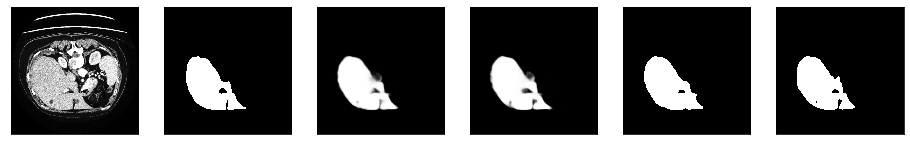

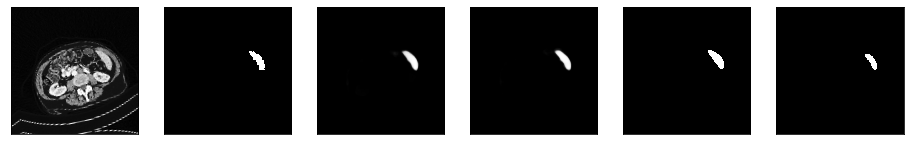

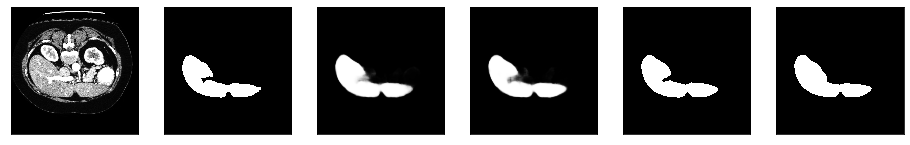

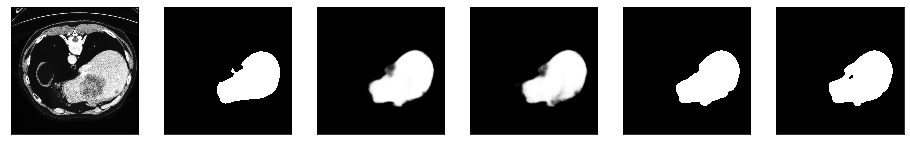

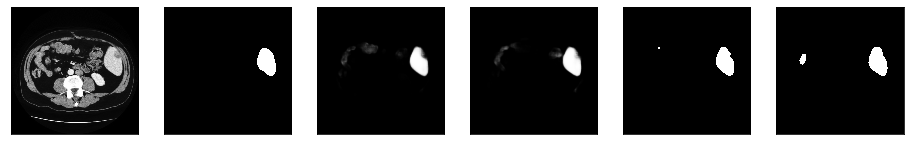

In [ ]:
models = load("models/lits_models.joblib")

predict_masks(models, lits_vdl, count=5)
# original image, ground truth, unet, wide unet, unet+, unet++

### UNet with ResNet101 backbone
- Instance segmentation on DSB 2018 dataset

100%|██████████| 670/670 [01:28<00:00,  7.61it/s]


Training batch shape: torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])
Validation batch shape: torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])


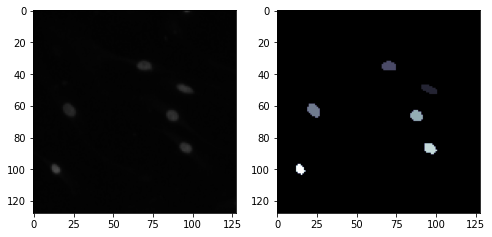

In [ ]:
iaugs = A.Compose([
    A.Resize(IMG_H, IMG_W), 
], p=1)

maugs = A.Compose([
    A.Resize(IMG_H, IMG_W, interpolation=Image.NEAREST)
], p=1)

bowl_ds = ResNetDS_Bowl(BOWL_, iaugs, maugs)
img, mask = bowl_ds.__getitem__(20)
visualize(img.reshape(IMG_H, IMG_W, 3), mask[0])

length = bowl_ds.__len__()
splits = [int(length - 0.2*length), int(0.2*length)] 
bowl_train, bowl_val = random_split(bowl_ds, splits)

bowl_tdl = DataLoader(bowl_train, batch_size=32, shuffle=True)
bowl_vdl = DataLoader(bowl_val, batch_size=32, shuffle=True)

train_features, train_labels = next(iter(bowl_tdl))
val_features, val_labels = next(iter(bowl_vdl))
print("Training batch shape:", train_features.size(), train_labels.size())
print("Validation batch shape:", val_features.size(), val_labels.size())

In [ ]:
model_loc = os.path.join('/gdrive', 'MyDrive', 'Assignment 2', 'models')

# normal unet
unet = UNet(3, 1, 2)
train(unet, bowl_tdl, bowl_vdl, epochs=51)

# wide unet
filters = [35, 70, 140, 280, 560]
w_unet = UNet(3, 1, filters)
train(w_unet, bowl_tdl, bowl_vdl, epochs=51)

# unet+ without deep supervision
unet_p = UNetplus(3, 1, 2)
train(unet_p, bowl_tdl, bowl_vdl, epochs=51)

# unet+ with deep supervision
unet_p_ds = UNetplus(3, 1, 2, ds=True)
train(unet_p_ds, bowl_tdl, bowl_vdl, ds=True, epochs=51)

# unet++ without deep supervision
unet_pp = UNetplusplus(3, 1, 2)
train(unet_pp, bowl_tdl, bowl_vdl, epochs=51)

# unet++ with deep supervision
unet_pp_ds = UNetplusplus(3, 1, 2, ds=True)
train(unet_pp_ds, bowl_tdl, bowl_vdl, ds=True, epochs=51)

dump([unet, w_unet, unet_p, unet_p_ds, unet_pp, unet_pp_ds], join(model_loc, "resunet_models.joblib"))

2021-07-07 11:53:12,972 - UNet++ - INFO - Started training for UNet for 51 epochs
2021-07-07 11:53:17,038 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.5384191274642944 	 Validation Loss: 2.2457761764526367
2021-07-07 11:53:17,470 - UNet++ - DEBUG - Mean IOU: 0.004446599632501602 	 Mean Dice Coef: 0.13276221847214612
2021-07-07 11:56:34,253 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.24704813957214355 	 Validation Loss: 0.2764816880226135
2021-07-07 11:56:34,706 - UNet++ - DEBUG - Mean IOU: 0.9147549558639526 	 Mean Dice Coef: 0.7595919789996227
2021-07-07 11:56:34,797 - UNet++ - INFO - Started training for UNet for 51 epochs
2021-07-07 11:56:40,240 - UNet++ - DEBUG - Epoch 1 	 Training Loss: 0.45862478017807007 	 Validation Loss: 0.497994601726532
2021-07-07 11:56:40,771 - UNet++ - DEBUG - Mean IOU: 0.7691397666931152 	 Mean Dice Coef: 0.12368091090686906
2021-07-07 12:01:02,883 - UNet++ - DEBUG - Epoch 51 	 Training Loss: 0.2756726145744324 	 Validation Loss: 0.305372953414917
202